In [17]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_obw, vlstm_fwbw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

## CUDA vLSTM forward backward

In [19]:
S = 16 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [20]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

### match directly

In [21]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [22]:
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)


In [23]:
# cuda kernel
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu, deltaDcsChunkArr_cu, deltaDcsVec_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [24]:
hs_cu2, n_cu2, m_cu2, matD_cu2 = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu2, dKs_cu2, dVs_cu2, dIgs_cu2, dFgs_cu2, matC_cu2, deltaDcsChunkArr_cu2, deltaDcsVec_cu2 = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu2,
    vec_m=m_cu2,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [25]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}")

print(f"delta Q match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"delta K match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"delta V match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"delta Igate match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(mat_R_pt - matC_cu))}")

fw hs match: True, max diff: 1.0728836059570312e-06
fw n match: True
fw m match: True
fw D match: True
delta Q match: True, max diff: 1.52587890625e-05
delta K match: True, max diff: 1.0967254638671875e-05
delta V match: True, max diff: 2.384185791015625e-06
delta Igate match: True, max diff: 8.58306884765625e-06
delta Fgate match: True, max diff: 1.9073486328125e-06
mat R match: True, max diff: 2.980232238769531e-07


dKs diff:


(tensor([[[[ 1.1323e+00,  1.4896e+00,  4.3527e+00, -9.6220e-01, -8.0719e-01, -1.0221e+00, -8.7821e-01, -1.7539e+00],
           [ 1.0980e-01, -9.3228e-02,  4.0265e-02, -3.2514e-01,  7.8870e-03,  1.3242e-01, -7.0079e-03,  1.7656e-02],
           [ 8.4860e-02, -4.0263e-01, -7.7269e-01, -4.5986e-01,  2.4837e-01,  6.4836e-01, -3.0721e-02,  4.0552e-01],
           [-8.5479e-01, -4.4952e-01,  2.7014e-01, -7.5713e-01, -1.3188e+00, -6.7318e-01,  1.7259e+00,  2.2943e+00],
           [-3.0690e-01, -3.0232e-01, -6.6310e-01, -4.8811e-01, -3.3322e-01, -1.3583e-01,  5.3421e-01,  6.5330e-01],
           [-7.5021e-01, -2.0454e+00, -4.5128e+00, -3.2690e+00,  1.3973e+00, -4.9834e+00,  6.0353e+00,  2.2838e+00],
           [ 1.3222e-01,  5.5558e-01,  1.4019e-01,  1.1796e-01,  6.1099e-01, -8.8516e-01, -1.6187e-01,  8.0124e-01],
           [ 1.5926e+00,  6.0508e-01,  1.3535e+00,  3.8358e-01, -9.6279e-01, -6.4273e-01, -8.7489e-01,  1.7413e+00],
           [-1.3686e+00,  1.9714e-01, -5.9340e-01, -1.1462e+00, 

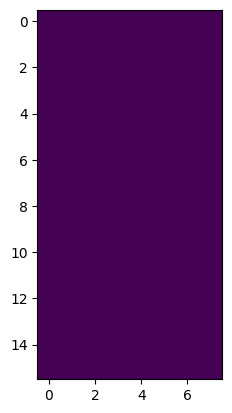

In [26]:
print(f"dKs diff:")
fig = plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

dVs diff:


(tensor([[[[ 1.0873e+00, -4.4177e-01,  4.6929e-01, -2.9993e-01,  4.2233e-01, -1.8083e+00,  7.0277e-03,  6.6185e-02],
           [-4.2191e-02,  1.5612e-01,  6.0103e-02,  2.9632e-01, -7.3016e-02, -1.0028e-01, -5.3693e-02, -4.4049e-02],
           [ 3.1099e-01, -1.0333e+00,  1.3535e-01, -1.3126e+00,  8.3534e-02, -2.4328e-01,  1.6256e-01,  4.9549e-01],
           [ 2.8295e+00, -1.2044e+00,  8.4270e-01, -1.4699e+00,  7.0279e-01,  4.9787e-01,  4.3429e-01, -1.5614e+00],
           [ 3.2594e-01, -2.8331e-02,  7.8929e-01,  2.0694e-01,  5.2784e-02, -1.5166e-01,  1.4601e-01,  4.8626e-01],
           [-1.1844e-02,  1.3908e+00,  1.0329e+00,  7.2264e-01,  1.3036e+00,  7.9459e-01, -2.0612e-01, -3.8972e-01],
           [ 5.6615e-01, -8.0189e-01, -4.1478e-01,  2.1942e+00, -1.2173e-01, -1.7003e+00,  8.0950e-01, -1.2527e+00],
           [-2.7504e-01,  2.7688e-01,  5.1827e-01,  1.8646e+00,  1.4617e+00,  7.6732e-02, -3.6635e-01,  3.4098e-01],
           [ 1.1084e-01, -3.9312e-01,  6.9533e-01, -7.3254e-01, 

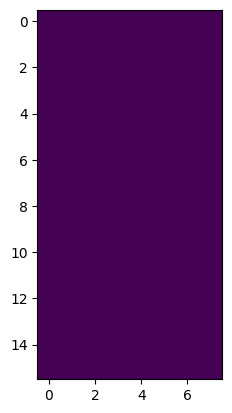

In [27]:
print(f"dVs diff:")
fig = plt.imshow(((dVs_cu - dVs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dVs_cu, dVs_pt, (dVs_cu - dVs_pt).abs() < BW_ATOL

fw hs match: True, max dev: 1.0728836059570312e-06
fw n match: True, max dev: 1.1920928955078125e-06
fw m match: True, max dev: 7.748603820800781e-07
fw D match: True, max dev: 1.0728836059570312e-06
delta Q match: True, max dev: 1.52587890625e-05
delta K match: True, max dev: 1.0967254638671875e-05
delta V match: True, max dev: 2.384185791015625e-06
delta Igate match: True, max dev: 8.58306884765625e-06
delta Fgate match: True, max dev: 1.9073486328125e-06
mat R match: True, max dev: 2.980232238769531e-07


(tensor([[[[ 1.1323e+00,  1.4896e+00,  4.3527e+00, -9.6220e-01, -8.0719e-01, -1.0221e+00, -8.7821e-01, -1.7539e+00],
           [ 1.0980e-01, -9.3228e-02,  4.0265e-02, -3.2514e-01,  7.8870e-03,  1.3242e-01, -7.0079e-03,  1.7656e-02],
           [ 8.4860e-02, -4.0263e-01, -7.7269e-01, -4.5986e-01,  2.4837e-01,  6.4836e-01, -3.0721e-02,  4.0552e-01],
           [-8.5479e-01, -4.4952e-01,  2.7014e-01, -7.5713e-01, -1.3188e+00, -6.7318e-01,  1.7259e+00,  2.2943e+00],
           [-3.0690e-01, -3.0232e-01, -6.6310e-01, -4.8811e-01, -3.3322e-01, -1.3583e-01,  5.3421e-01,  6.5330e-01],
           [-7.5021e-01, -2.0454e+00, -4.5128e+00, -3.2690e+00,  1.3973e+00, -4.9834e+00,  6.0353e+00,  2.2838e+00],
           [ 1.3222e-01,  5.5558e-01,  1.4019e-01,  1.1796e-01,  6.1099e-01, -8.8516e-01, -1.6187e-01,  8.0124e-01],
           [ 1.5926e+00,  6.0508e-01,  1.3535e+00,  3.8358e-01, -9.6279e-01, -6.4273e-01, -8.7489e-01,  1.7413e+00],
           [-1.3686e+00,  1.9714e-01, -5.9340e-01, -1.1462e+00, 

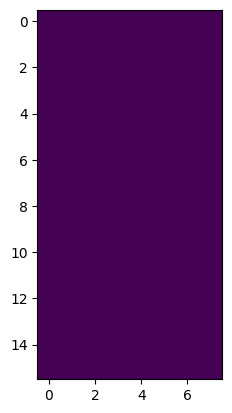

In [28]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu2, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(hs_cu2 - hs_pt).max()}")
print(f"fw n match: {torch.allclose(n_cu2, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(n_cu2 - n_pt).max()}")
print(f"fw m match: {torch.allclose(m_cu2, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs(m_cu2 - m_pt).max()}")
print(f"fw D match: {torch.allclose((matD_cu2 - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max dev: {torch.abs((matD_cu2 - matD_pt).tril()).max()}")

print(f"delta Q match: {torch.allclose(dQs_cu2, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dQs_cu2 - dQs_pt).max()}")
print(f"delta K match: {torch.allclose(dKs_cu2, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dKs_cu2 - dKs_pt).max()}")
print(f"delta V match: {torch.allclose(dVs_cu2, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dVs_cu2 - dVs_pt).max()}")
print(f"delta Igate match: {torch.allclose(dIgs_cu2, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dIgs_cu2 - dIgs_pt).max()}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu2, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(dFgs_cu2 - dFgs_pt).max()}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu2, rtol=BW_RTOL, atol=BW_ATOL)}, max dev: {torch.abs(mat_R_pt - matC_cu2).max()}")
plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

In [29]:
dKs_cu, dKs_cu2, dKs_pt

(tensor([[[[ 1.1323e+00,  1.4896e+00,  4.3527e+00, -9.6220e-01, -8.0719e-01, -1.0221e+00, -8.7821e-01, -1.7539e+00],
           [ 1.0980e-01, -9.3228e-02,  4.0265e-02, -3.2514e-01,  7.8870e-03,  1.3242e-01, -7.0079e-03,  1.7656e-02],
           [ 8.4860e-02, -4.0263e-01, -7.7269e-01, -4.5986e-01,  2.4837e-01,  6.4836e-01, -3.0721e-02,  4.0552e-01],
           [-8.5479e-01, -4.4952e-01,  2.7014e-01, -7.5713e-01, -1.3188e+00, -6.7318e-01,  1.7259e+00,  2.2943e+00],
           [-3.0690e-01, -3.0232e-01, -6.6310e-01, -4.8811e-01, -3.3322e-01, -1.3583e-01,  5.3421e-01,  6.5330e-01],
           [-7.5021e-01, -2.0454e+00, -4.5128e+00, -3.2690e+00,  1.3973e+00, -4.9834e+00,  6.0353e+00,  2.2838e+00],
           [ 1.3222e-01,  5.5558e-01,  1.4019e-01,  1.1796e-01,  6.1099e-01, -8.8516e-01, -1.6187e-01,  8.0124e-01],
           [ 1.5926e+00,  6.0508e-01,  1.3535e+00,  3.8358e-01, -9.6279e-01, -6.4273e-01, -8.7489e-01,  1.7413e+00],
           [-1.3686e+00,  1.9714e-01, -5.9340e-01, -1.1462e+00, 

In [30]:
from kernel_call_checks.multicall_fwbw import check_multi_kernel_calls_fwbw, check_multi_kernel_calls_fw

In [31]:
N = 100
check_multi_kernel_calls_fw(q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

100%|██████████| 100/100 [00:00<00:00, 2138.57it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S

In [32]:
N = 100
check_multi_kernel_calls_fwbw(dH=dHs,q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

  0%|          | 0/100 [00:00<?, ?it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S

 75%|███████▌  | 75/100 [00:00<00:00, 743.23it/s]

In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, b

100%|██████████| 100/100 [00:00<00:00, 674.77it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
===== FW =====
hs correct/total: 100/100
n corre